ПРОГРАММНАЯ РЕАЛИЗАЦИЯ DTMF ФИЛЬТРАЦИИ

1. ПАРАМЕТРЫ СИГНАЛА:
   Длительность: 0.01 сек
   Частота дискретизации: 100000 Гц
   Количество отсчетов: 1000

2. DTMF ЧАСТОТЫ ЦИФРЫ '1':
   Низкая частота: 697 Гц
   Высокая частота: 1209 Гц

3. ХАРАКТЕРИСТИКИ СИГНАЛА:
   Диапазон значений: -28221 до 35017

4. ПРОЕКТИРОВАНИЕ FIR-ФИЛЬТРА:
   Частота Найквиста: 50000.0 Гц
   Полоса пропускания: 650-1250 Гц
   Количество коэффициентов: 63
   Групповая задержка: 31 отсчетов
   Диапазон коэффициентов: -16 до 759


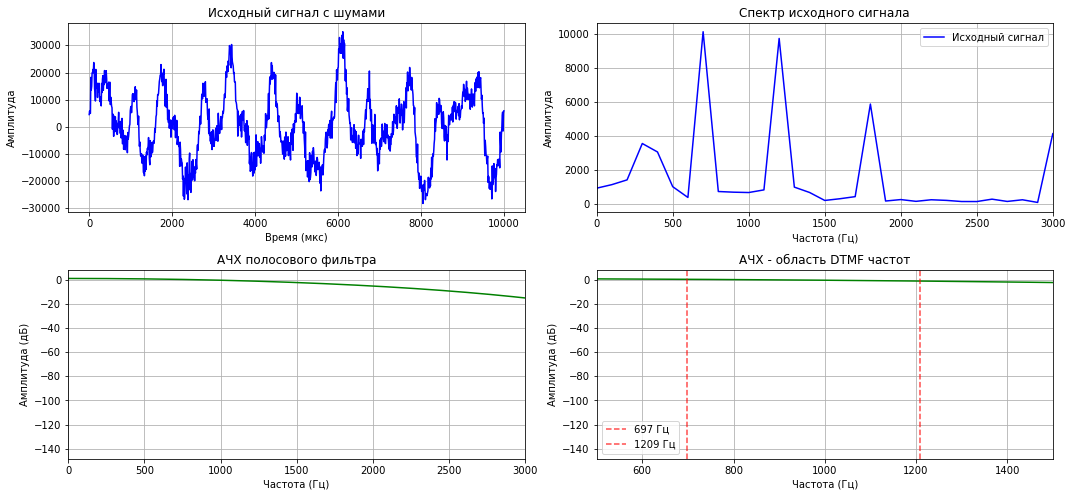


5. ПРОГРАММНАЯ ФИЛЬТРАЦИЯ:
   Запуск FIR-фильтрации...
   Время фильтрации: 0.0199 сек


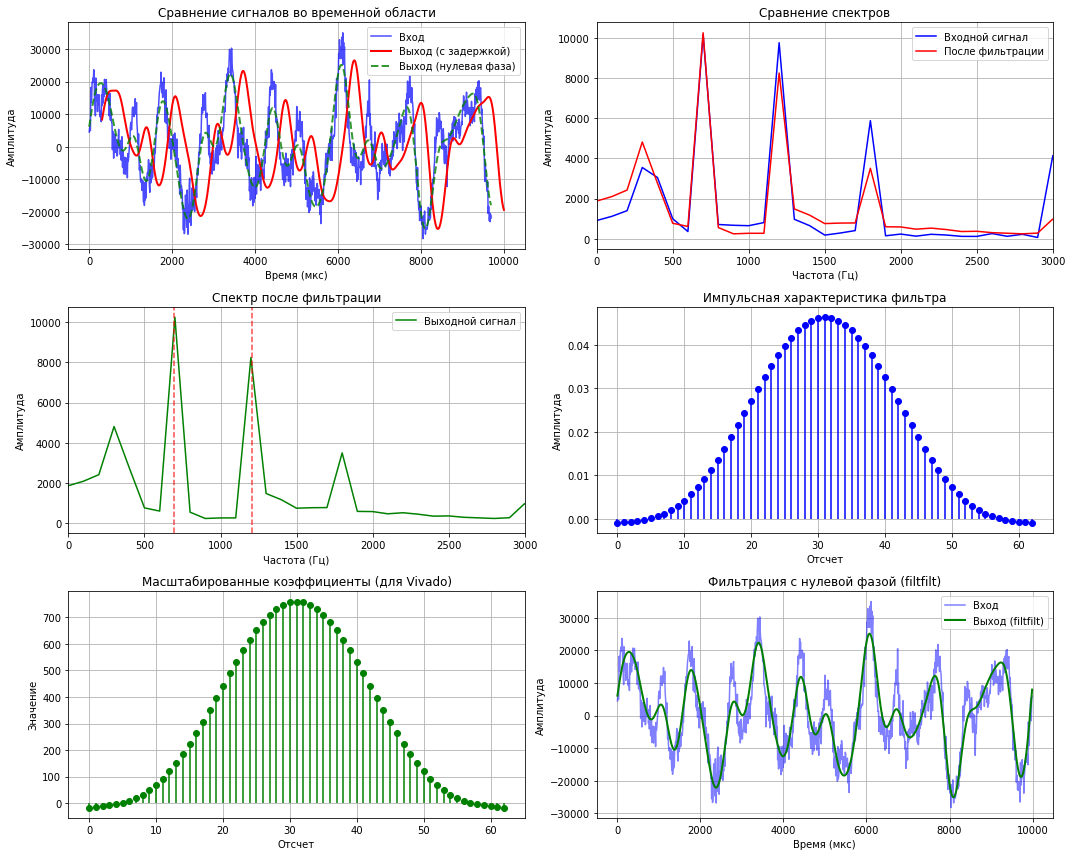


6. АНАЛИЗ РЕЗУЛЬТАТОВ ФИЛЬТРАЦИИ:
   МОЩНОСТЬ В ПОЛОСЕ DTMF (600-1300 Гц):
     До фильтрации:    6287084914887.98
     После фильтрации: 6351267048141.71
     Сохранение:             101.0%

   МОЩНОСТЬ ШУМА ВНЕ ПОЛОСЫ DTMF:
     До фильтрации:    1322967088025.08
     После фильтрации: 1711133085182.86
     Подавление шума:          0.8 раз

   ОТНОШЕНИЕ СИГНАЛ/ШУМ (SNR):
     До фильтрации:           4.75
     После фильтрации:        3.71
     Улучшение SNR:            0.8 раз

7. ПОДГОТОВКА ДАННЫХ ДЛЯ VIVADO:
   Коэффициенты для Vivado (63 точек):
   Первые 10 коэффициентов: -16,-13,-10,-7,-3,2,9,19,32,49...

   Коэффициенты сохранены в файл: dtmf_fir_coeffs.txt

8. СВОДКА РЕЗУЛЬТАТОВ:
   ✓ DTMF сигнал цифры '1' сгенерирован
   ✓ Добавлены шумы на 350 Гц, 1800 Гц, 3000 Гц
   ✓ Спроектирован полосовой FIR-фильтр (63 коэффициентов)
   ✓ Компенсирована групповая задержка (31 отсчетов)
   ✓ Выполнена программная фильтрация
   ✓ Время обработки: 0.0199 сек
   ✓ Коэффициенты подготовле

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter, firwin, freqz, filtfilt
import time

def plot_signals(time_sec, in_signal, out_signal=None, n_samples=2000):
    """Функция для отображения сигналов во временной области"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(time_sec[:n_samples]*1e6, in_signal[:n_samples], 'b-', label='Входной сигнал', alpha=0.7)
    if out_signal is not None:
        plt.plot(time_sec[:n_samples]*1e6, out_signal[:n_samples], 'r-', label='Выход фильтра', linewidth=2)
    plt.xlabel('Время (мкс)')
    plt.ylabel('Амплитуда')
    plt.title('Сигналы во временной области')
    plt.grid(True)
    plt.legend()

def plot_spectrum(signal, fs, title, color='b'):
    """Функция для отображения спектра сигнала"""
    N = len(signal)
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, 1/fs)[:N//2]
    
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), color=color, label=title)
    plt.xlabel('Частота (Гц)')
    plt.ylabel('Амплитуда')
    plt.grid(True)
    plt.xlim(0, 3000)

def band_power(signal, fs, f_low, f_high):
    """Вычисление мощности сигнала в заданной полосе частот"""
    N = len(signal)
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, 1/fs)
    
    # Индексы частот в заданном диапазоне
    idx = np.where((xf >= f_low) & (xf <= f_high))[0]
    idx = idx[idx < N//2]  # Только положительные частоты
    
    if len(idx) > 0:
        power = np.sum(np.abs(yf[idx])**2) / len(idx)
    else:
        power = 0
    return power

# =============================================================================
# 1. ПАРАМЕТРЫ СИГНАЛА И ГЕНЕРАЦИЯ DTMF
# =============================================================================

print("=" * 60)
print("ПРОГРАММНАЯ РЕАЛИЗАЦИЯ DTMF ФИЛЬТРАЦИИ")
print("=" * 60)

# Параметры сигнала
T = 0.01  # Длительность сигнала
fs = 100000  # Частота дискретизации 100 кГц
n = int(T * fs)  # Количество отсчетов
t = np.linspace(0, T, n, endpoint=False)  # Временной вектор

print(f"\n1. ПАРАМЕТРЫ СИГНАЛА:")
print(f"   Длительность: {T} сек")
print(f"   Частота дискретизации: {fs} Гц")
print(f"   Количество отсчетов: {n}")

# DTMF частоты для цифры "1"
freq_low = 697   # Низкая частота
freq_high = 1209 # Высокая частота

print(f"\n2. DTMF ЧАСТОТЫ ЦИФРЫ '1':")
print(f"   Низкая частота: {freq_low} Гц")
print(f"   Высокая частота: {freq_high} Гц")

# Генерация чистого DTMF сигнала
dtmf_signal = np.sin(2 * np.pi * freq_low * t) + np.sin(2 * np.pi * freq_high * t)

# Добавление шумов на разных частотах
noise_low = 0.5 * np.sin(2 * np.pi * 350 * t)     # Низкочастотный шум
noise_mid = 0.6 * np.cos(2 * np.pi * 1800 * t)    # Среднечастотный шум  
noise_high = 0.4 * np.sin(2 * np.pi * 3000 * t)   # Высокочастотный шум
noise_random = 0.3 * np.random.randn(n)           # Случайный шум

# Суммируем сигнал с шумами
noisy_signal = dtmf_signal + noise_low + noise_mid + noise_high + noise_random

# Масштабируем для лучшего отображения
samples = noisy_signal * 10000
samples = samples.astype(np.int32)

print(f"\n3. ХАРАКТЕРИСТИКИ СИГНАЛА:")
print(f"   Диапазон значений: {np.min(samples)} до {np.max(samples)}")

# =============================================================================
# 2. ПРОЕКТИРОВАНИЕ ПОЛОСОВОГО FIR-ФИЛЬТРА
# =============================================================================

print(f"\n4. ПРОЕКТИРОВАНИЕ FIR-ФИЛЬТРА:")
nyquist = fs / 2  # Частота Найквиста

# Границы полосы пропускания (около DTMF частот)
low_cutoff = 650   # Нижняя граница
high_cutoff = 1250 # Верхняя граница

print(f"   Частота Найквиста: {nyquist} Гц")
print(f"   Полоса пропускания: {low_cutoff}-{high_cutoff} Гц")

# Создаем полосовой FIR-фильтр с линейной фазой
taps = 63  # Количество коэффициентов (нечетное для линейной фазы)
coeffs = firwin(taps, [low_cutoff/nyquist, high_cutoff/nyquist], 
                pass_zero=False, window='hamming')

print(f"   Количество коэффициентов: {taps}")
print(f"   Групповая задержка: {taps//2} отсчетов")

# Масштабируем коэффициенты для 16-битного представления
scale_factor = 2**14
coeffs_scaled = np.round(coeffs * scale_factor).astype(np.int32)

print(f"   Диапазон коэффициентов: {np.min(coeffs_scaled)} до {np.max(coeffs_scaled)}")

# Анализируем АЧХ фильтра
w, h = freqz(coeffs, worN=8000)
frequencies = w * nyquist / np.pi

# =============================================================================
# 3. ВИЗУАЛИЗАЦИЯ ИСХОДНОГО СИГНАЛА И АЧХ ФИЛЬТРА
# =============================================================================

plt.figure(figsize=(15, 10))

# Исходный сигнал
plt.subplot(3, 2, 1)
plt.plot(t[:2000]*1e6, samples[:2000], 'b-')
plt.title('Исходный сигнал с шумами')
plt.xlabel('Время (мкс)')
plt.ylabel('Амплитуда')
plt.grid(True)

# Спектр исходного сигнала
plt.subplot(3, 2, 2)
plot_spectrum(samples, fs, 'Исходный сигнал', 'b')
plt.title('Спектр исходного сигнала')
plt.legend()

# АЧХ фильтра
plt.subplot(3, 2, 3)
plt.plot(frequencies, 20 * np.log10(np.abs(h)), 'g')
plt.title('АЧХ полосового фильтра')
plt.xlabel('Частота (Гц)')
plt.ylabel('Амплитуда (дБ)')
plt.grid(True)
plt.xlim(0, 3000)

# АЧХ фильтра (увеличенный масштаб)
plt.subplot(3, 2, 4)
plt.plot(frequencies, 20 * np.log10(np.abs(h)), 'g')
plt.title('АЧХ - область DTMF частот')
plt.xlabel('Частота (Гц)')
plt.ylabel('Амплитуда (дБ)')
plt.grid(True)
plt.xlim(500, 1500)
plt.axvline(freq_low, color='r', linestyle='--', alpha=0.7, label=f'{freq_low} Гц')
plt.axvline(freq_high, color='r', linestyle='--', alpha=0.7, label=f'{freq_high} Гц')
plt.legend()

plt.tight_layout()
plt.show()

# =============================================================================
# 4. ПРОГРАММНАЯ ФИЛЬТРАЦИЯ С КОМПЕНСАЦИЕЙ ЗАДЕРЖКИ
# =============================================================================

print(f"\n5. ПРОГРАММНАЯ ФИЛЬТРАЦИЯ:")
print("   Запуск FIR-фильтрации...")

start_time = time.time()
# Используем фильтрацию с нулевой начальной фазой (filtfilt для компенсации задержки)
sw_fir_output_zero_phase = filtfilt(coeffs, 1.0, samples.astype(float))

# Также делаем обычную фильтрацию для сравнения
sw_fir_output = lfilter(coeffs, 1.0, samples.astype(float))
stop_time = time.time()
sw_exec_time = stop_time - start_time

print(f"   Время фильтрации: {sw_exec_time:.4f} сек")

# Преобразуем обратно в int32 для сравнения
sw_fir_output_int = sw_fir_output.astype(np.int32)
sw_fir_output_zero_phase_int = sw_fir_output_zero_phase.astype(np.int32)

# =============================================================================
# 5. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ФИЛЬТРАЦИИ
# =============================================================================

plt.figure(figsize=(15, 12))

# Сравнение сигналов во временной области (с компенсацией задержки)
plt.subplot(3, 2, 1)
delay = taps // 2  # Компенсация групповой задержки

# Корректируем размеры для правильного отображения
n_plot = min(2000, len(samples) - delay)
plt.plot(t[:n_plot]*1e6, samples[:n_plot], 'b-', alpha=0.7, label='Вход')
plt.plot(t[delay:delay+n_plot]*1e6, sw_fir_output_int[delay:delay+n_plot], 'r-', label='Выход (с задержкой)', linewidth=2)
plt.plot(t[:n_plot]*1e6, sw_fir_output_zero_phase_int[:n_plot], 'g--', label='Выход (нулевая фаза)', linewidth=2, alpha=0.8)
plt.title('Сравнение сигналов во временной области')
plt.xlabel('Время (мкс)')
plt.ylabel('Амплитуда')
plt.grid(True)
plt.legend()

# Сравнение спектров
plt.subplot(3, 2, 2)
plot_spectrum(samples, fs, 'Входной сигнал', 'b')
plot_spectrum(sw_fir_output_int, fs, 'После фильтрации', 'r')
plt.title('Сравнение спектров')
plt.legend()

# Спектр после фильтрации (детальный)
plt.subplot(3, 2, 3)
plot_spectrum(sw_fir_output_int, fs, 'Выходной сигнал', 'g')
plt.title('Спектр после фильтрации')
plt.axvline(freq_low, color='r', linestyle='--', alpha=0.7)
plt.axvline(freq_high, color='r', linestyle='--', alpha=0.7)
plt.legend()

# Импульсная характеристика фильтра (исправленная)
plt.subplot(3, 2, 4)
markerline, stemlines, baseline = plt.stem(range(taps), coeffs, linefmt='b-', markerfmt='bo', basefmt=" ")
plt.setp(stemlines, 'color', 'b')
plt.setp(markerline, 'color', 'b')
plt.title('Импульсная характеристика фильтра')
plt.xlabel('Отсчет')
plt.ylabel('Амплитуда')
plt.grid(True)

# Масштабированные коэффициенты (исправленная)
plt.subplot(3, 2, 5)
markerline, stemlines, baseline = plt.stem(range(taps), coeffs_scaled, linefmt='g-', markerfmt='go', basefmt=" ")
plt.setp(stemlines, 'color', 'g')
plt.setp(markerline, 'color', 'g')
plt.title('Масштабированные коэффициенты (для Vivado)')
plt.xlabel('Отсчет')
plt.ylabel('Значение')
plt.grid(True)

# Сравнение с нулевой фазой
plt.subplot(3, 2, 6)
plt.plot(t[:2000]*1e6, samples[:2000], 'b-', alpha=0.5, label='Вход')
plt.plot(t[:2000]*1e6, sw_fir_output_zero_phase_int[:2000], 'g-', label='Выход (filtfilt)', linewidth=2)
plt.title('Фильтрация с нулевой фазой (filtfilt)')
plt.xlabel('Время (мкс)')
plt.ylabel('Амплитуда')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# =============================================================================
# 6. АНАЛИЗ ЭФФЕКТИВНОСТИ ФИЛЬТРАЦИИ
# =============================================================================

print(f"\n6. АНАЛИЗ РЕЗУЛЬТАТОВ ФИЛЬТРАЦИИ:")
print("   " + "=" * 40)

# Мощность в полосе DTMF (используем сигнал с компенсированной задержкой)
dtmf_power_input = band_power(samples, fs, 600, 1300)
dtmf_power_output = band_power(sw_fir_output_zero_phase_int, fs, 600, 1300)

# Мощность вне полосы DTMF
noise_power_input = (band_power(samples, fs, 0, 600) + 
                    band_power(samples, fs, 1300, 5000))
noise_power_output = (band_power(sw_fir_output_zero_phase_int, fs, 0, 600) + 
                     band_power(sw_fir_output_zero_phase_int, fs, 1300, 5000))

print(f"   МОЩНОСТЬ В ПОЛОСЕ DTMF (600-1300 Гц):")
print(f"     До фильтрации:    {dtmf_power_input:12.2f}")
print(f"     После фильтрации: {dtmf_power_output:12.2f}")
print(f"     Сохранение:       {dtmf_power_output/dtmf_power_input*100:11.1f}%")

print(f"\n   МОЩНОСТЬ ШУМА ВНЕ ПОЛОСЫ DTMF:")
print(f"     До фильтрации:    {noise_power_input:12.2f}")
print(f"     После фильтрации: {noise_power_output:12.2f}")
if noise_power_output > 0:
    suppression = noise_power_input / noise_power_output
    print(f"     Подавление шума:  {suppression:11.1f} раз")
else:
    print(f"     Подавление шума:  полное")

# Вычисляем SNR до и после
snr_input = dtmf_power_input / noise_power_input if noise_power_input > 0 else float('inf')
snr_output = dtmf_power_output / noise_power_output if noise_power_output > 0 else float('inf')

print(f"\n   ОТНОШЕНИЕ СИГНАЛ/ШУМ (SNR):")
print(f"     До фильтрации:    {snr_input:11.2f}")
print(f"     После фильтрации: {snr_output:11.2f}")
if snr_input > 0:
    print(f"     Улучшение SNR:    {snr_output/snr_input:11.1f} раз")

# =============================================================================
# 7. ПОДГОТОВКА К АППАРАТНОЙ РЕАЛИЗАЦИИ
# =============================================================================

print(f"\n7. ПОДГОТОВКА ДАННЫХ ДЛЯ VIVADO:")
print("   " + "=" * 40)

# Формируем строку коэффициентов для Vivado
coeffs_string = ','.join(str(x) for x in coeffs_scaled)

print(f"   Коэффициенты для Vivado ({taps} точек):")
# Показываем первые 10 коэффициентов для примера
print("   Первые 10 коэффициентов: " + ','.join(str(x) for x in coeffs_scaled[:10]) + "...")

# Сохраняем коэффициенты в файл
with open('dtmf_fir_coeffs.txt', 'w') as f:
    f.write(coeffs_string)

print(f"\n   Коэффициенты сохранены в файл: dtmf_fir_coeffs.txt")

print(f"\n8. СВОДКА РЕЗУЛЬТАТОВ:")
print("   " + "=" * 40)
print(f"   ✓ DTMF сигнал цифры '1' сгенерирован")
print(f"   ✓ Добавлены шумы на 350 Гц, 1800 Гц, 3000 Гц")
print(f"   ✓ Спроектирован полосовой FIR-фильтр ({taps} коэффициентов)")
print(f"   ✓ Компенсирована групповая задержка ({delay} отсчетов)")
print(f"   ✓ Выполнена программная фильтрация")
print(f"   ✓ Время обработки: {sw_exec_time:.4f} сек")
print(f"   ✓ Коэффициенты подготовлены для Vivado")
print(f"\n   Программная реализация завершена успешно!")
print("   " + "=" * 60)